# **Objective**
#### **This notebook** is dedicated to exploring the application of **Long Short-Term Memory (LSTM)** models for **image captioning** on a small dataset. **Image captioning** is a fascinating task that **combines computer vision** and **natural language processing** to **generate** meaningful **textual descriptions based on visual content**. The primary aim is to provide a **detailed guide** for individuals interested in **constructing and comprehending LSTM models**. This step-by-step tutorial **elucidates** the process of **building** a model **based on LSTM** for image captioning tasks.

### What is an **LSTM**?
> ##### **Long Short-Term Memory (LSTM)** is a **type of recurrent neural network (RNN)** architecture designed to **handle sequential data**. LSTMs are particularly adept at capturing **long-range dependencies** and are widely utilized in various tasks, including (NLP) and other sequence-to-sequence tasks. **Unlike traditional RNNs**, LSTMs **are equipped** with memory cells and gating mechanisms, allowing them to **effectively address the vanishing gradient** problem and capture temporal dependencies.

> 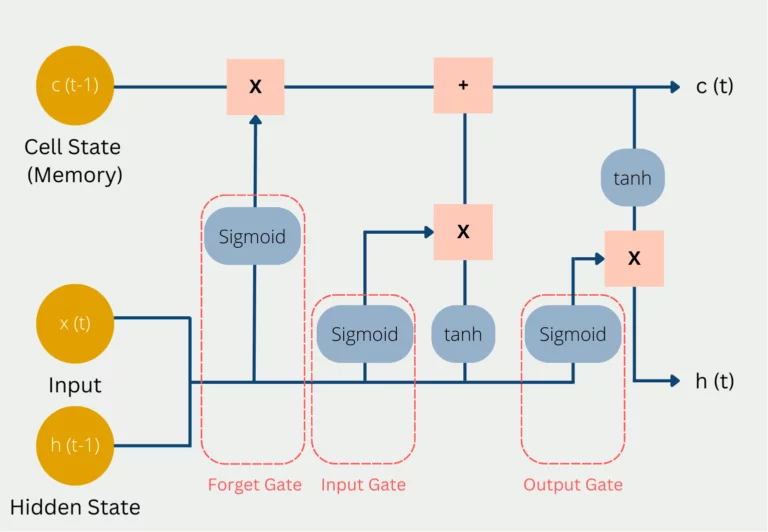

> ##### **Input Gate:** The input gate **controls** how much of the **new information** should be added **to the cell state**.
> ##### **Forget Gate:** The forget gate decides **what information from the previous cell** state should be **discarded**.
> ##### **Update of Cell State:** The cell state is updated **based on the input gate, forget gate,** and a new **candidate** cell state
> ##### **Output Gate:** The output gate **determines** the **next hidden state** based on the updated cell state.
> ##### **Final Hidden State:** The final hidden state is **determined** by the **output gate** and the **updated cell state**

## **Methodology:**
> #### 1. **Data and Pre-processing:**
> ##### The **Flickr8k** dataset is utilized, and pre-processing involves **caption normalization**, and dataset splitting. Image processing includes conversion to arrays, and **feature extraction** using a pre-trained **Inception v3** model are applied. The dataset is prepared using **generators** for **optimized memory usage** during training.

> #### 2. **Model Architecture:**
> ##### **The encoder** employs normalization and **dense layers** to **align dimensions** with the decoder. **The decoder** incorporates **an embedding layer**, and **an LSTM layer**. **Ultimately** an Add layer and **two Dense layers** serve as the **output layers**.

> #### 3. **Training:**
> ##### **The training** process involves utilizing **image features** as inputs **for the encoder** and their corresponding five **captions** as inputs for **the decoder**. At each time step, the **image features** (x_image) **are combined with partial captions** (x_captions) **up to the current time step**, while **the target captions** (y_target) **represent the next word** in the sequence. The primary objective during training is to iteratively **update the model's weights**, **minimizing the loss** and enhancing its ability to generate accurate and coherent captions.

> #### 4. **Inference:**
> ##### **Greedy algorithm** and **Beam Search** combined with **BLEU score evaluation** are employed for generating captions on test set.

## Library setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

# Data and Pre-processing

In [2]:
# Path to the images
images_directory = '/kaggle/input/flickr8k/Images/'
# Path to the captions
captions_path = '/kaggle/input/flickr8k/captions.txt'

In [3]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

## Cleaning the captions

In [4]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [5]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

## Visualizing some of the images along with their corresponding captions

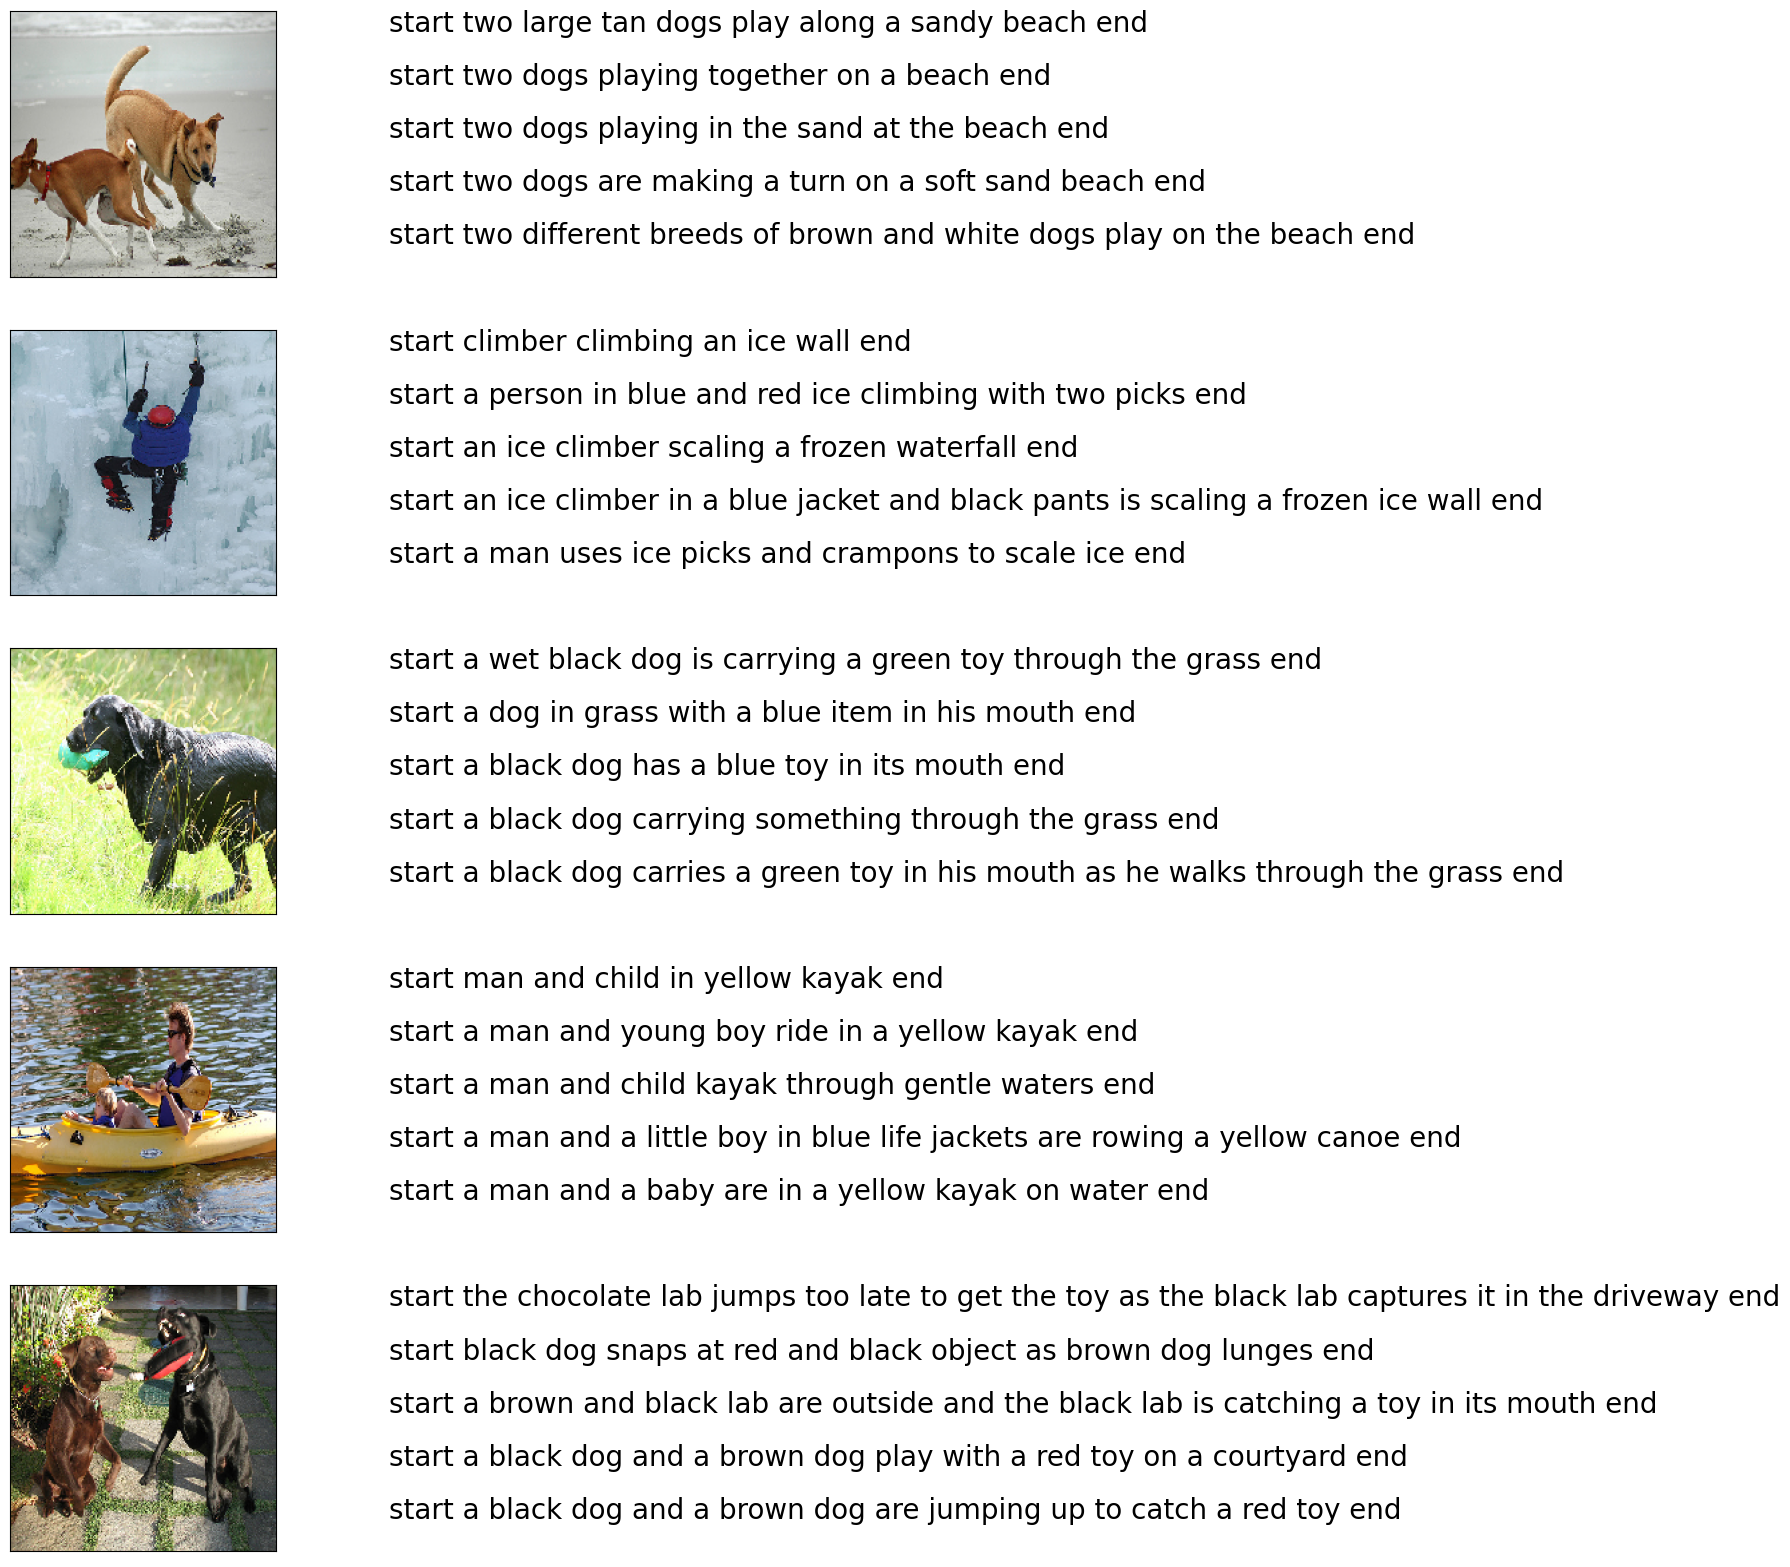

In [6]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

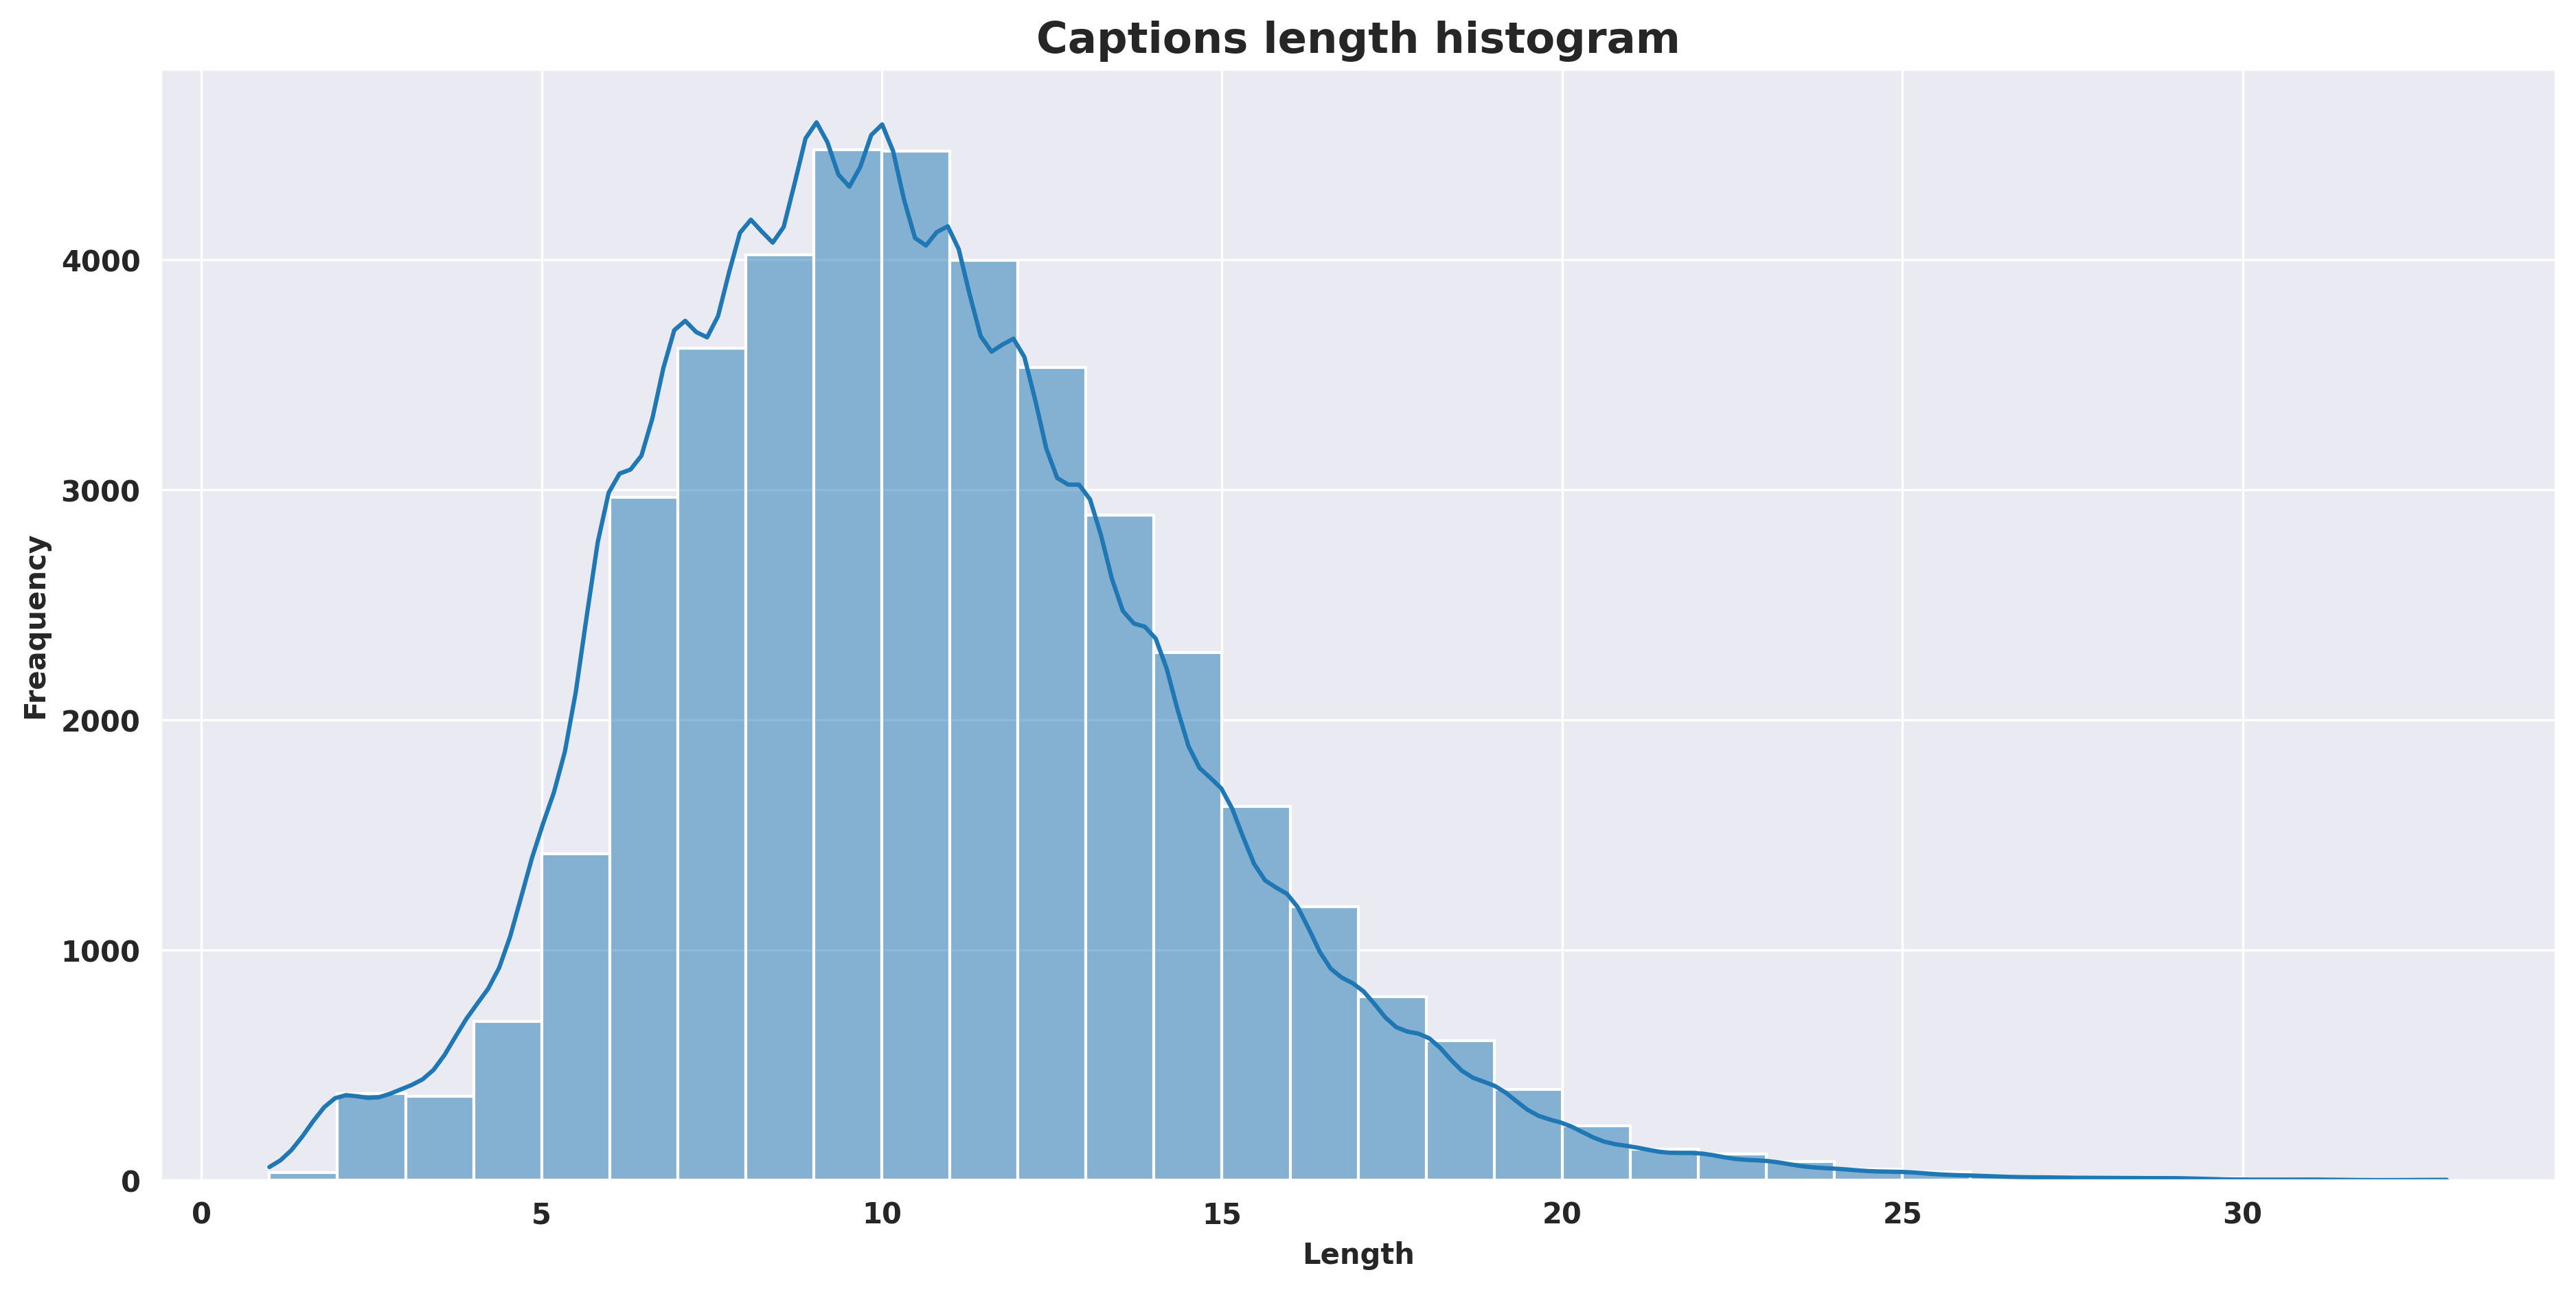

In [7]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(cleaned_captions)

In [8]:
def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    # Splitting the text into words and count occurrences
    word_counts = Counter(all_text.split())

    words = list(word_counts.keys())[1:30]
    values = list(word_counts.values())[1:30]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])

    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions (except for letter \'a\')', title_font=dict(size=23, family='Balto'))

    fig.show()
    
word_occurrences(cleaned_captions)

### **Tokenizing** captions and setting **vocab size**

In [9]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

### Splitting the data into tain, validation and test sets

In [10]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

## **Extracting Image features** using **The InceptionV3** model

In [11]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


In [12]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs       

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green') 

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features
    
    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    else:
        print('Unknown image ID !')
    
pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

# **Data Setup for Model Input**
> #### To **optimize** memory usage, it's suggested to use **generators** to collect the data

In [13]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield [np.array(X_images), np.array(X_captions)], np.array(y)
         
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [14]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3230, 2048)
X_captions: (3230, 34)
y: (3230, 8586)
Validation sample batch shapes:
X_images: (1676, 2048)
X_captions: (1676, 34)
y: (1676, 8586)


# **Defining** the **Image Captioning** Model

> ### **Encoder** (image features)
> * Input Layer
> * Batch Normalization Layer
> * Dense Layer
> * Batch Normalization Layer

> ### **Decoder** (captions)
> * Input Layer
> * Embedding Layer
> * **LSTM** Layer

> ### **Output**
> * Add Layer (Encoder output + Decoder output)
> * Dense Layer + ReLU activation function
> * Dense Layer + Softmax activation function

In [15]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)
    
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, 2048)        8192        ['Features_Input[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['batch_normalizat

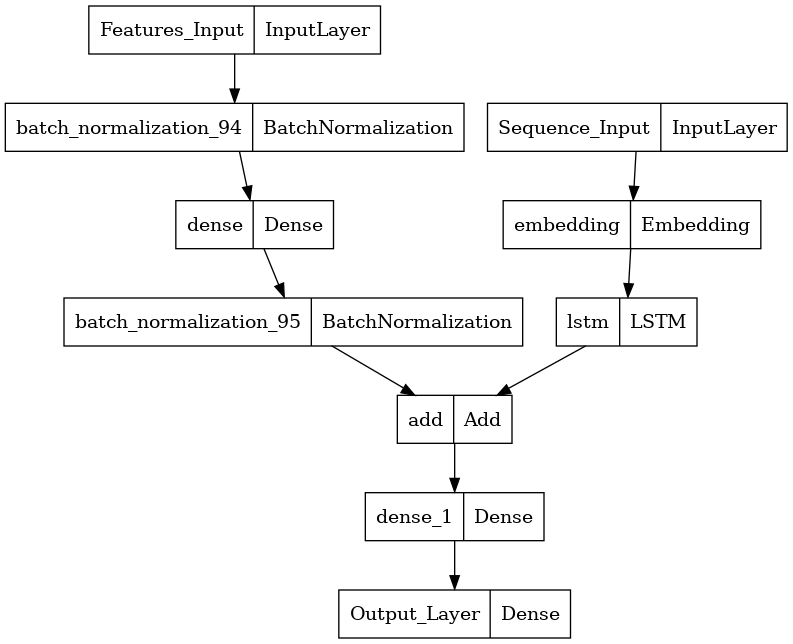

In [16]:
plot_model(caption_model)

# Training the model
##### **Training** will **stop** if there is **no improvement** in the **validation loss** for **3 consecutive epochs**.

In [17]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 [==============================] - 59s 412ms/step - loss: 4.5193 - val_loss: 3.7587 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 46s 363ms/step - loss: 3.2788 - val_loss: 3.3721 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 46s 367ms/step - loss: 2.8868 - val_loss: 3.2566 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 46s 364ms/step - loss: 2.6674 - val_loss: 3.2166 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 46s 365ms/step - loss: 2.5308 - val_loss: 3.2102 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 46s 361ms/step - loss: 2.4477 - val_loss: 3.2135 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 46s 364ms/step - loss: 2.3978 - val_loss: 3.2198 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 46s 362ms/step - loss: 2.3697 - val_loss: 3.2241 - lr: 8.2297e-05


### Visualizing the model performance

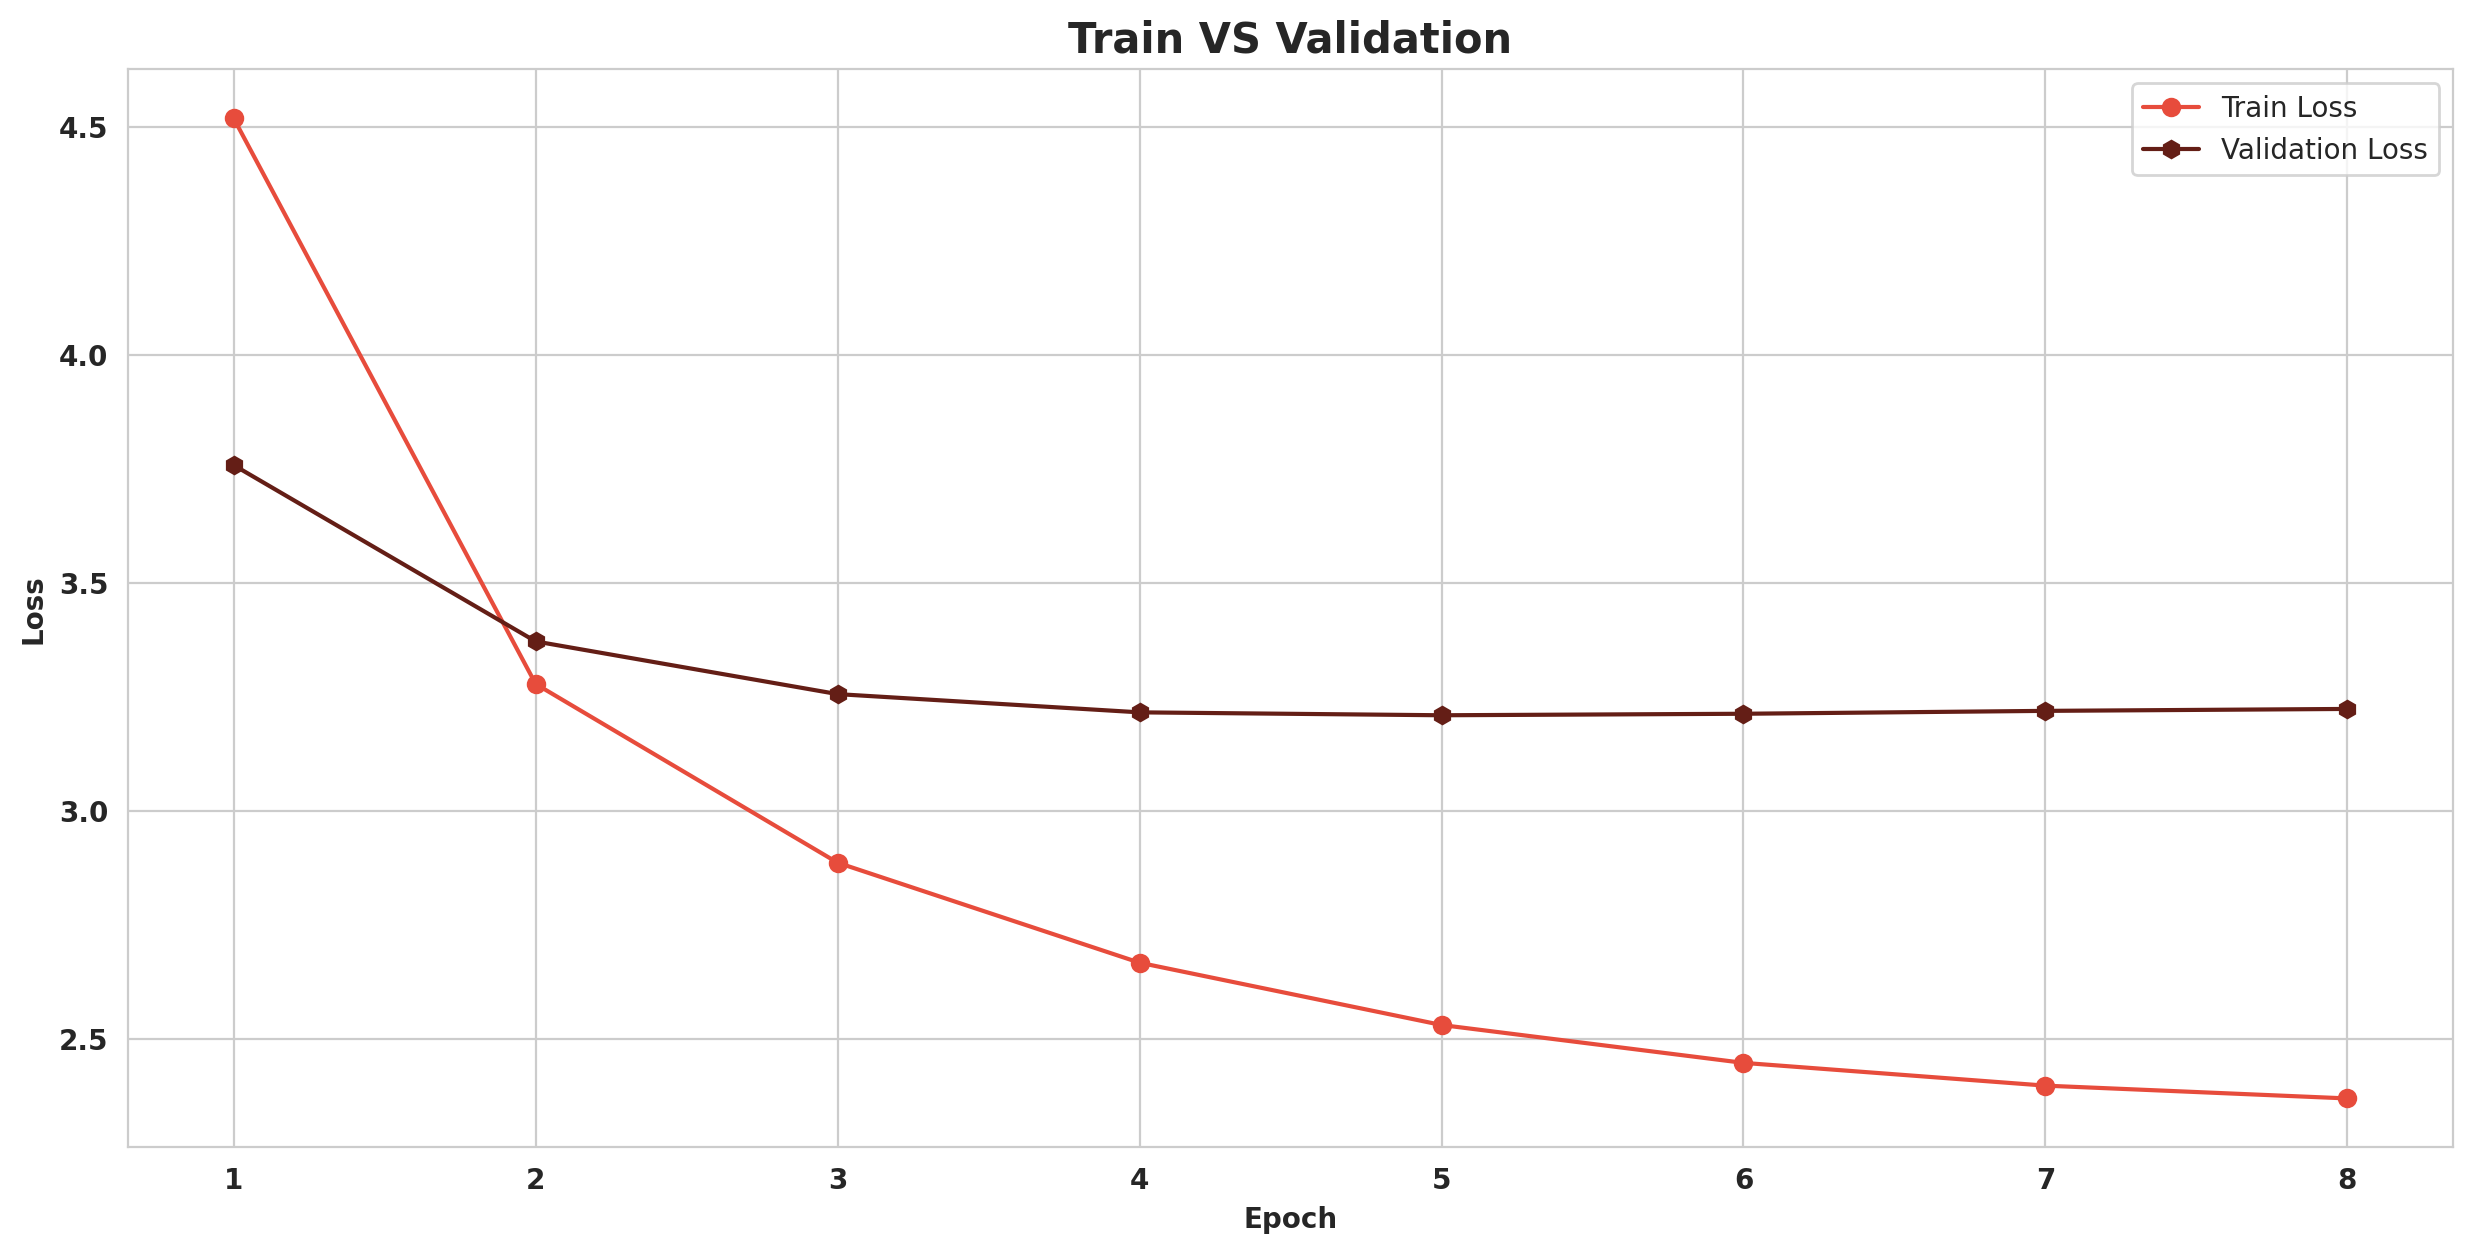

In [18]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

# Inference
> ##### **Caption Generation:** At **each time step**, **the model takes** as input **the image features** along with **the generated words** (starting with start at the first time step), **predicting the probabilities** of **the next word**.
> ##### **Greedy algorithm:** To select  **the best caption**, **the greedy algorithm** is employed. This method, chooses **the most probable word** at each time step and **appends it** to the generated captions **until** the selected word is the **end** token, **or the length** of the decoded captions exceeds  **the maximum sequence length**.
> ##### **Beam Search:** Beam Search is an **alternative** to the greedy algorithm for **selecting captions**. It **maintains** a beam of **multiple hypotheses** (candidate captions) at each time step. At each step, **the model predicts** the next word for **each hypothesis**. **The top-k candidates** (based on probabilities) **are retained** in the beam. The process **continues until** the **end token** is generated **or the maximum sequence length** is reached.
> ##### **Evaluation** is performed using the **BLEU score**
> ##### **Visualization:** The function visualization() plots the **images along with their corresponding predicted captions, accompanied by 2 BLEU scores**.

In [19]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [20]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Sequence of most probable words based on the previous steps
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            
            # Sorting predictions by the probability and taking the last K_beams items.
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            # Getting the top <K_beams>(n) predictions and creating a 
            #                              new list so as to put them via the model again.
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [21]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy, beam_search):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [22]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [23]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

## Visualizing some of the **test images** along with their corresponding **generated captions**

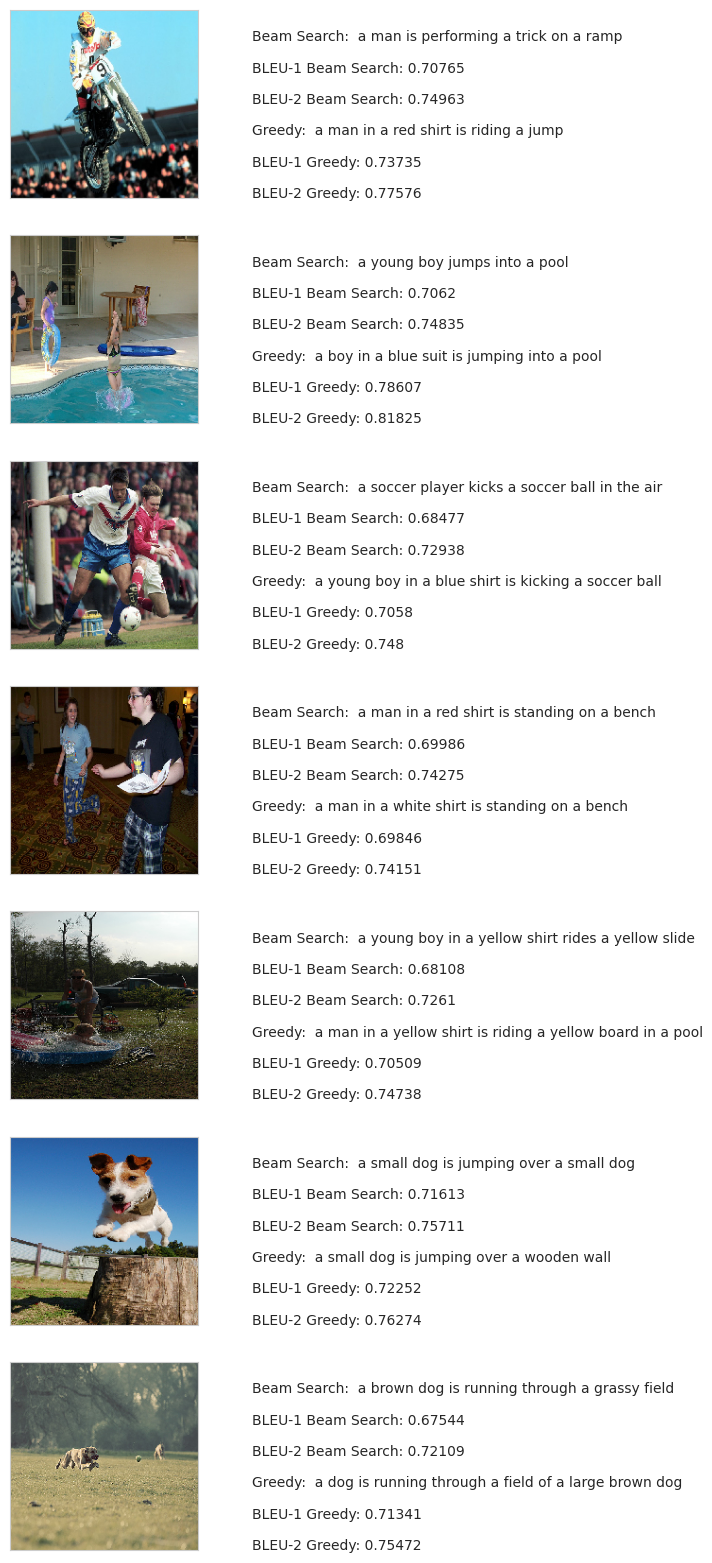

In [24]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token
        
        # Generating captions
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])
        
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))
    
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

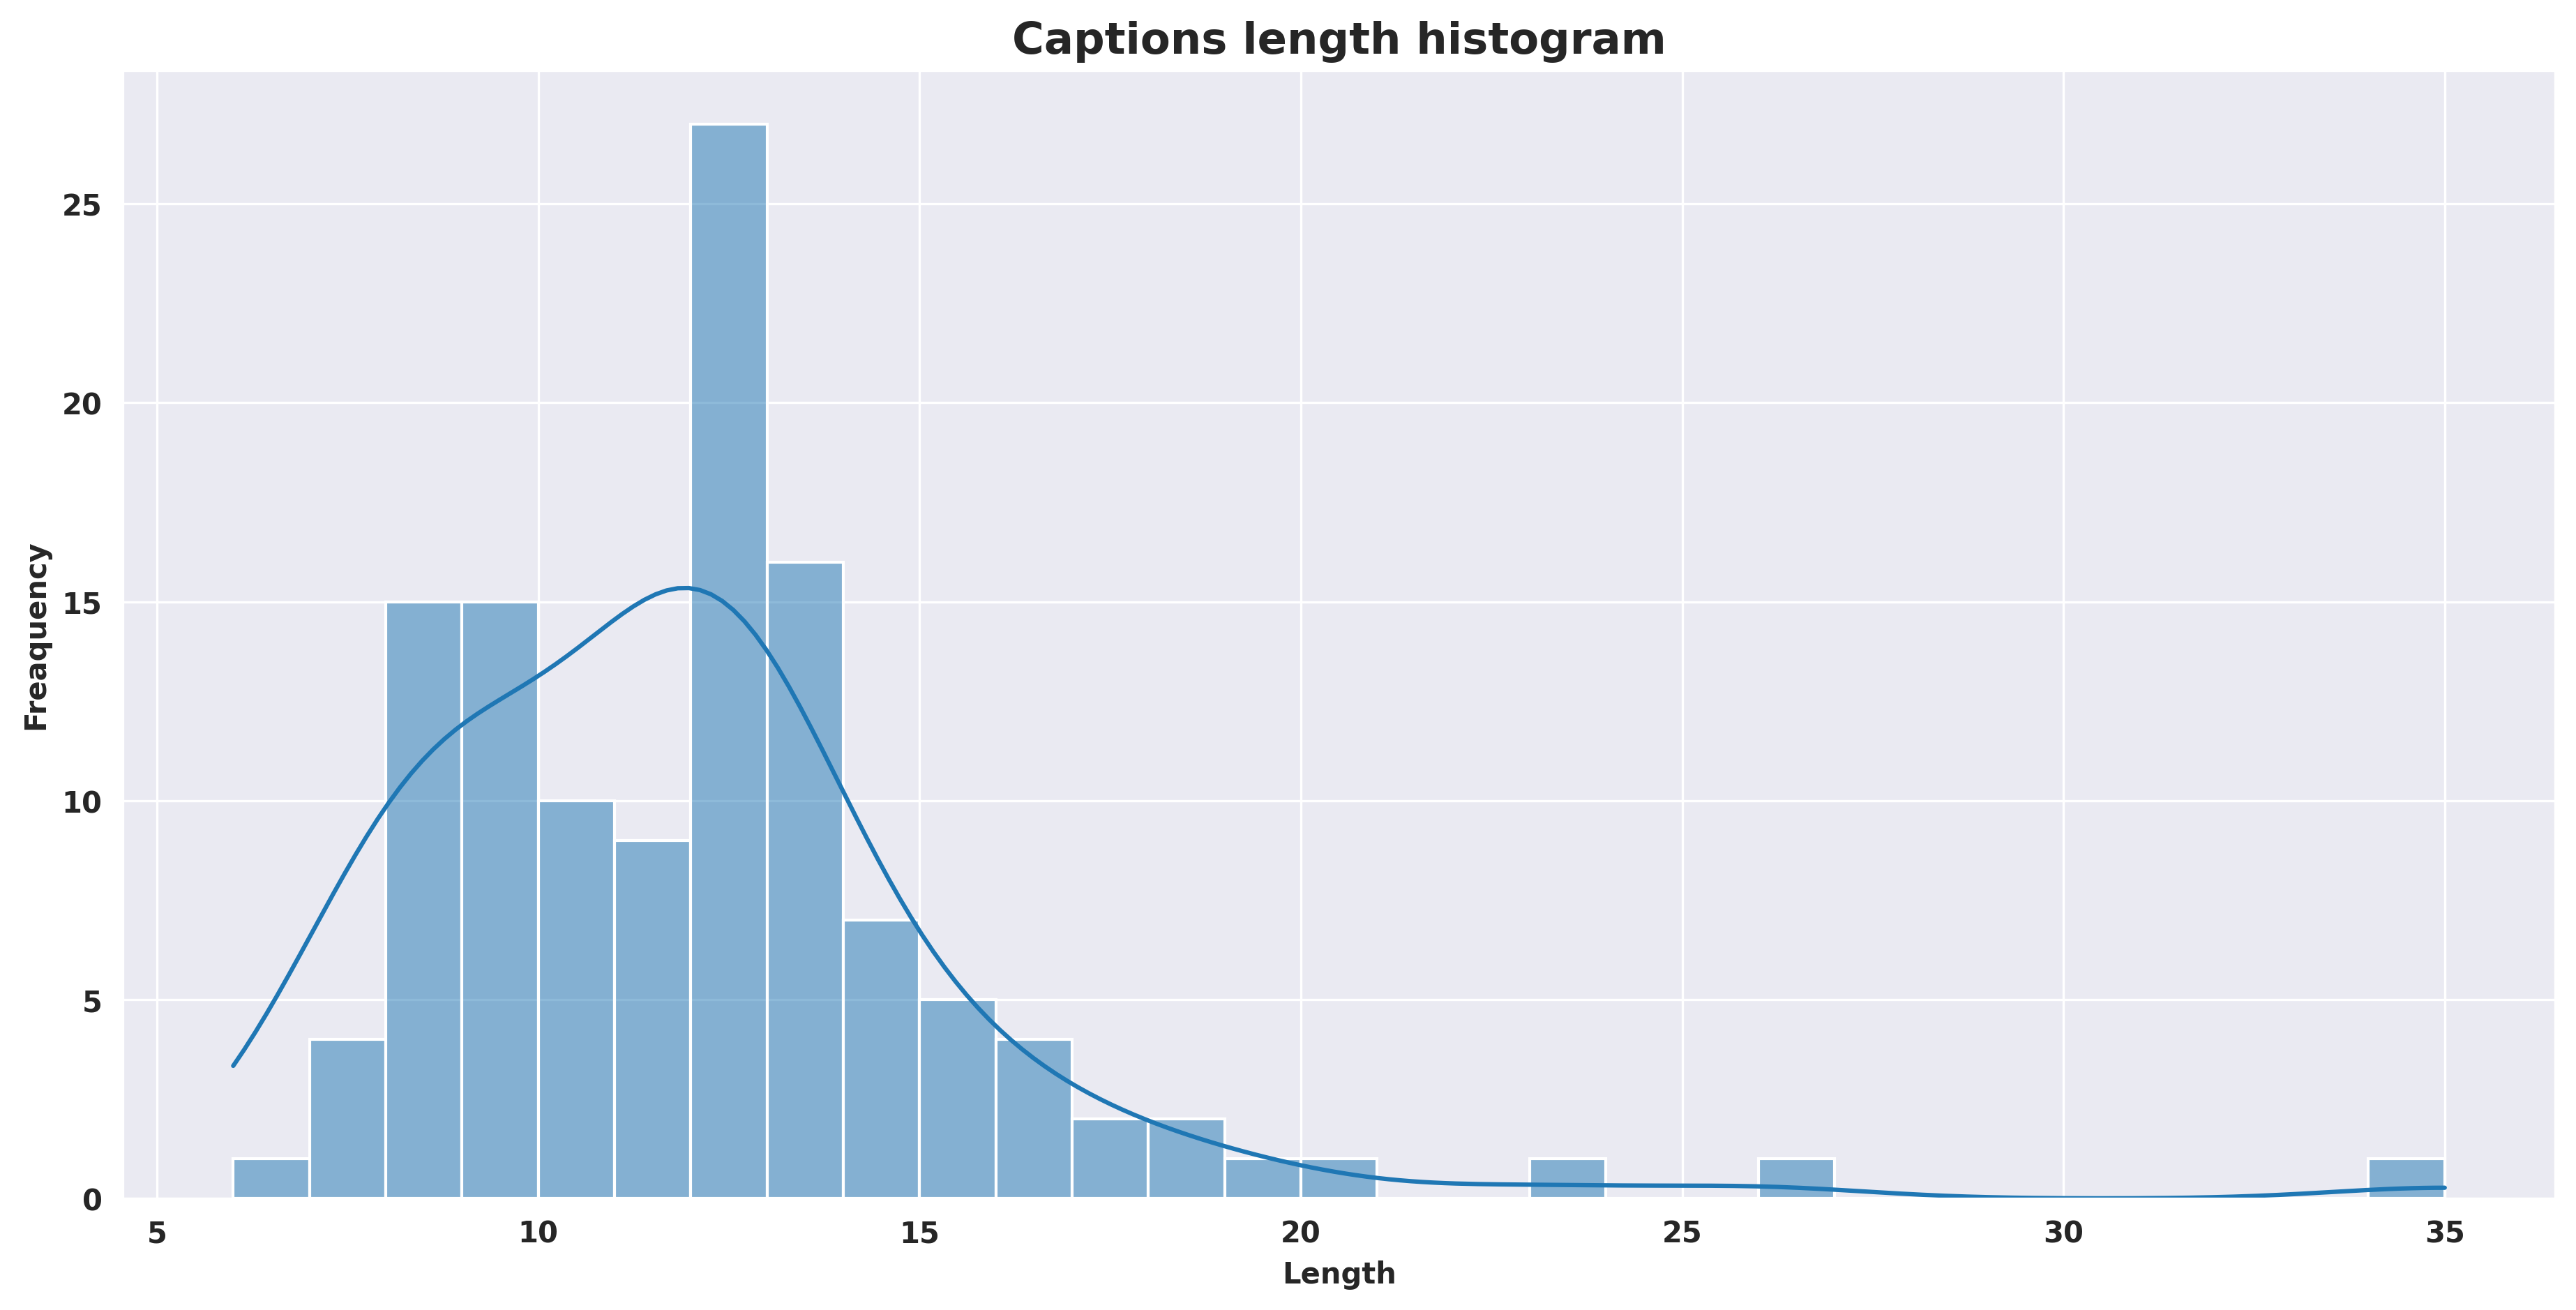

In [25]:
captions_length(list(generated_captions.values()))

In [26]:
word_occurrences(list(generated_captions.values()))

## Better results achieved by utilizing  transformers on both the Flickr8k and Flickr30k datasets.
> #### For those interested in exploring this further, here are the relevant resources:
> #### Transformers for Flickr8k: https://www.kaggle.com/code/saeedghamshadzai/image-captioning-transformers-flickr8k
> #### Transformers for Flickr30k: https://www.kaggle.com/code/saeedghamshadzai/image-captioning-transformers-flickr30k

## **Thank you** for taking the time to explore this notebook. I hope you found it both **enjoyable** and **informative**. **Please consider upvoting, sharing**, and **trying out** the concepts presented. **Feel free to share your thoughts, questions, or suggestions** in the **comment section** below.

# **Happy coding!**